<h1 style="font-size:30px;">Implementing LeNet-5 in PyTorch</h1>

In this notebook, we will build a model of the LenNet-5 CNN architecture in PyTorch, and we will use it to perform classification on the MNIST dataset that we used in Week 2. LetNet-5 is a small CNN model that was first introduced in 1998 [LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf). Even though this network is very small, it performs much better than a standard MLP network because CNNs are much more effective at processing image data. This will also be an opportunity for us to add a little more structure to the code that we develop in order to formalize the training process by encapsulating the various steps into functions that allow us to build more modular code.

<img src='https://opencv.org/wp-content/uploads/2023/05/c3_week3_LeNet-5_architecture.png' width=1000 align='center'><br/>

## Table of Contents

* [1 System Configuration](#1-System-Configuration)
* [2 Training Configuration](#2-Training-Configuration)
* [3 Dataset Processing](#3-Dataset-Processing)
* [4 Modeling the LeNet5 Architecture](#4-Modeling-the-LeNet5-Architecture)
* [5 Training Pipeline](#5-Training-Pipeline)
* [6 Plot Training Results](#6-Plot-Training-Results)
* [7 Model Evaluation and Plotting Predictions](#7-Model-Evaluation-and-Plotting-Predictions)
* [8 Conclusion](#8-Conclusion)

In [ ]:
# Uncooment the line below, if you are using Colab.
!pip install torchinfo

We shall first begin with our imports.

In [ ]:
import os
import random
import math
import numpy as np
import time
import copy

from tqdm import tqdm

import requests
from zipfile import ZipFile

from dataclasses import dataclass
from typing import List, Tuple, Union

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.optim import lr_scheduler

from torchvision import datasets, transforms as T
from torchvision.transforms import functional

from torchinfo import summary

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)

%matplotlib inline

In [ ]:
bold = f"\033[1m"
reset = f"\033[0m"

## 1 System Configuration

We need to set the required seeds to make the results **reproducible**.

In [ ]:
def set_seeds():
    # fix random seeds
    SEED_VALUE = 42

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True


set_seeds()

## 2 Training Configuration

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 10
    IMG_HEIGHT:  int = 32
    IMG_WIDTH:   int = 32
    BATCH_SIZE:  int = 32
    NUM_WORKERS: int = 2
    DATA_ROOT:   str = "DATA_MNIST"


@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS:         int   = 20
    LEARNING_RATE:  float = 1e-2
    CHECKPOINT_DIR: str   = "DATA_MNIST_CHECKPOINTS"
    DEVICE:         str   = "cuda"

For training on `cpu`, you san set the following configurations:

- **`TrainingConfig`**:
  * `DEVICE = "cpu"`

## 3 Dataset Processing

We will use the MNIST dataset that you are now familiar with.

<img src='https://opencv.org/wp-content/uploads/2023/05/c3_week2_MNIST_Digits.png' width=650 align='center'>

### 3.1 Define Preprocessing Transforms

Before we start for preparing our dataset, it is essential to resize our data to some fixed dimensions. The `image_preprocess_transforms` resizes the image data to a shape of `(32, 32)` and converts them to a tensor which normalizes the image data in the range `[0., 1.]`. Besides, it also transposes the dimensions from `[H, W, C]` to `[C, H, W]`.

Finally the image data needs to be **normalized** again, using the appropriate mean and standard deviation.

In other words, following equation is used for Normalization across each image channel, $C$:

$$ \hat x_C = \frac{x_C - \mu_C}{\sigma_C}$$

For MNIST, we only have have a single channel. Its **mean** and **standard deviation** have already been computed, and turns out to be `(.1307,)` and `(.3081,)` respectively.

In [ ]:
def image_preprocess_transforms(img_size: Tuple[int] = (32,32)):

    preprocess = T.Compose([
                    # Resize image data to img_size.
                    T.Resize(img_size, antialias=True),
                    # Convert (H,W,C) to (C,H,W) and normalize data to [0., 1.].
                    # by dividing with 255.
                    T.ToTensor(),
                    # Subtract mean (0.1307) and divide by variance (0.3081).
                    # This mean and variance is calculated on training data.
                    T.Normalize(mean=[.1307,], std=[.3081,])
                 ])

    return preprocess

### 3.2 Download and Read the Dataset

In [ ]:
def get_data(img_size, root_dir):

    train_test_transforms = image_preprocess_transforms(img_size)

    if os.path.exists(root_dir):
        download = False
    else:
        download = True

    train_dataset = datasets.MNIST(
                             root=root_dir,
                             download=download,
                             train=True,
                             transform=train_test_transforms
                        )

    test_dataset = datasets.MNIST(
                            root=root_dir,
                            download=download,
                            train=False,
                            transform=train_test_transforms
                        )

    return train_dataset, test_dataset

### 3.3 Create the Train, Validation and Test Data Loaders

In [ ]:
def create_data_loaders(train_set, test_set, batch_size, num_workers=1, seed=42):

    torch.manual_seed(seed)
    # Split train_dataset into 90-10 train-val splits
    train_data, valid_data = random_split(train_set, [.9, .1])


    # Train dataloader
    train_loader = DataLoader(
                        train_data,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=num_workers
                    )
    # Validation loader
    valid_loader = DataLoader(
                        valid_data,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers)

    # Test loader
    test_loader = DataLoader(
                        test_set,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers
                    )


    # Print stats.
    print("Dataset Statistics:\n")
    print(f"There are {len(train_data)} training examples")
    print(f"There are {len(valid_data)} validation examples")
    print(f"There are {len(test_set)} test examples")
    print(f"Image data shape: {train_set[0][0].shape}")
    print(f"There are {len(train_set.classes)} classes")
    print("\n\n")

    return train_loader, valid_loader, test_loader

### 3.4 Data Visualization

It's always a good idea to explore the dataset you are using. We have already used the MNIST dataset before, but it's good to build a small function that can easily display a small portion of the dataset.

In [ ]:
def visualize_samples(sample_set):

    plt.figure(figsize=(18, 8))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.grid(False)
        plt.imshow(sample_set[i][0].permute(1,2,0), cmap='gray')
        plt.xlabel(sample_set[i][1])
        plt.axis("off")

    plt.suptitle('Dataset Samples', fontsize=18)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show(block=block_plot)
    plt.close()

In [ ]:
data_config = DatasetConfig()

# Download the MNIST dataset.
train_set, test_set = get_data(
                       img_size=(data_config.IMG_HEIGHT, data_config.IMG_WIDTH),
                       root_dir=data_config.DATA_ROOT)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]


Extracting DATA_MNIST/MNIST/raw/train-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 347kB/s]


Extracting DATA_MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.78MB/s]


Extracting DATA_MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.0MB/s]


Extracting DATA_MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw



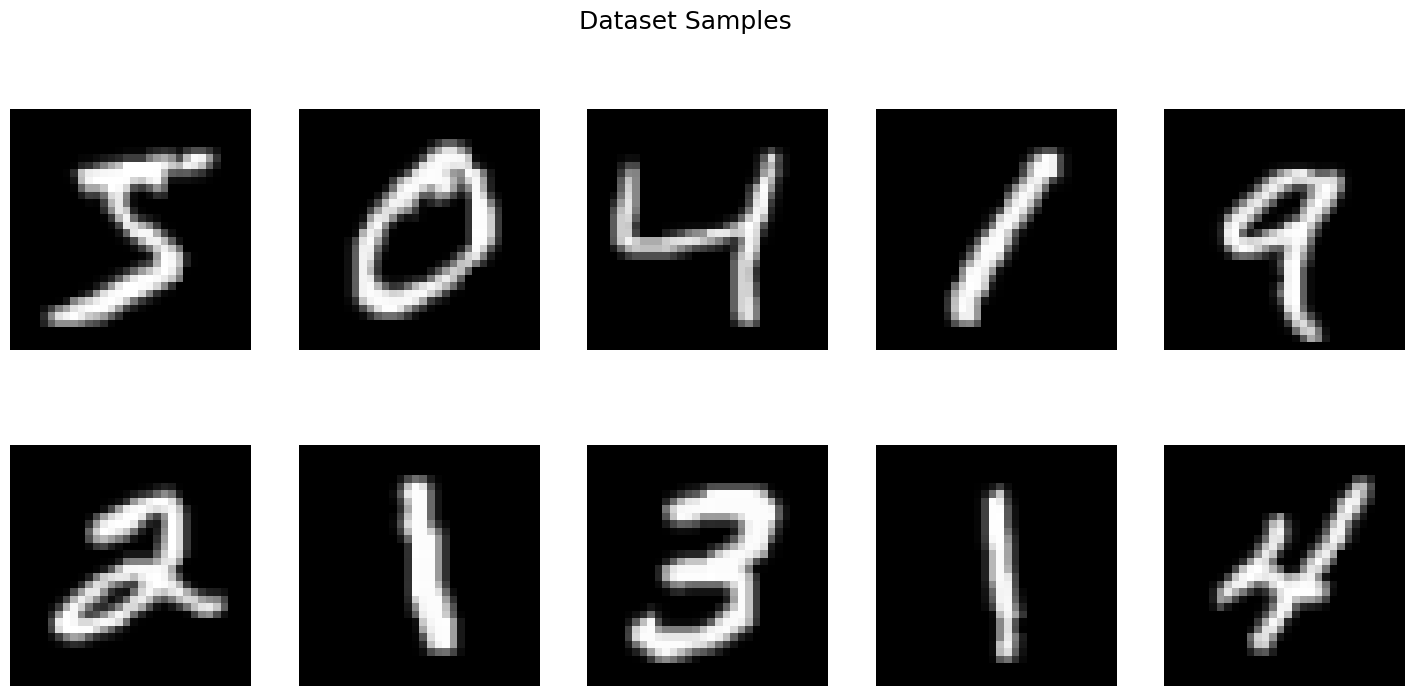

In [ ]:
visualize_samples(train_set)

## 4 Modeling the LeNet5 Architecture

This network has two convolutional layers and three fully connected layers. The model architecture can be then divided into two parts:


1. **`_body`**: This implements the Convolutional part of the network, which consists of the two convolutional layers. Each convolutional layer is followed by a pooling layer. In classical Machine Learning terms, it also works as a feature extractor.
2. **`_head`**: This implements the fully-connected part of the network. It consists of three fully-connected layers, with the last layer having ten output classes.

### 4.1 Convolutional Layer Function Syntax


```python
torch.nn.Conv2d(in_channels, out_channels,
                kernel_size, stride=1, padding=0,
                dilation=1, groups=1, bias=True, padding_mode='zeros',
                device=None, dtype=None)
```

Where,

* `in_channels`: number of input channels. For example, for colored image inputs, in_channel must be `3`. If out_channels of the first conv2d layer is `6` then in_channels of the second conv2d layer must be `6`.
<br>
* `out_channels`: The dimensionality of the output space (i.e. the number of output filters in the convolution).
</br>

* `kernel_size`: `int` or a `tuple of int`. If it is `int`, height and width will be the same. If it is a `tuple of int`, the first element will be the height (number of rows) of filter, while second element denotes its width (number of columns) of the filter.
<br>
* `padding`: controls the amount of padding applied to the input. It can be either a `string` {‘valid’, ‘same’} or an `int` or a `tuple of ints` giving the amount of implicit padding applied on both sides. Here, `padding='valid'` is the same as no padding, whereas, `padding='same'` pads the input so the output has the shape as the input. If it is `int` same padding will be done across the height and width. The default is `zero` padding.
<br>
* `stride`: An `int` or a `tuple or list of 2 ints`, specifying the strides of the convolution along the height and width. It can be a single integer to specify the same value for all spatial dimensions.
<br>
* `bias`: `Boolean`, whether the layer uses a bias vector (default is `True`).


The full documentation is available here:  [Conv2D Documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d).

**Note:** There is no activation after the last `Linear` layer. So while during inference, if we want probability as the output, we need to pass the model output through `softmax`.

### 4.2 LeNet-5 Model

In this section, we are going to implement the LeNet-5 model in PyTorch using the `nn.Module`. This particualr model is slightly different from the original version which used Average Pooling and Tanh activations. Here, we will use Max Pooling and Relu activations.

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            # First convolution Layer
            # input size = (32, 32), output size = (28, 28)
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            # ReLU activation
            nn.ReLU(inplace=True),
            # Max pool 2-d
            nn.MaxPool2d(kernel_size=2),

            # Second convolution layer
            # input size = (14, 14), output size = (10, 10)
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # output size = (5, 5)
        )

        # Fully connected layers
        self._head = nn.Sequential(
            # First fully connected layer
            # in_features = total number of weights in last conv layer = 16 * 5 * 5
            nn.Linear(in_features=16 * 5 * 5, out_features=120),

            # ReLU activation
            nn.ReLU(inplace=True),

            # second fully connected layer
            # in_features = output of last linear layer = 120
            nn.Linear(in_features=120, out_features=84),

            # ReLU activation
            nn.ReLU(inplace=True),

            # Third fully connected layer. It is also output layer
            # in_features = output of last linear layer = 84
            # and out_features = number of classes = 10 (MNIST data 0-9)
            nn.Linear(in_features=84, out_features=num_classes)
        )

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weights_in_last conv_layer
        x = x.view(x.shape[0], -1)
        # apply classification head
        x = self._head(x)
        return x

## 5 Training Pipeline

The `create_checkpoint_dir` utility function creates the specified directory to save the model with the best weights.

In [ ]:
def create_checkpoint_dir(checkpoint_dir):

    # Create a new checkpoint directory every time.
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    print(f"Checkpoint directory: {checkpoint_dir}")
    return checkpoint_dir

### 5.1 Define Train Step

The `train` function defines the training steps for model. This is where the model weights are updated  using backprop. We shall also print the loss and the accuracy for each epoch as the training progresses.

The following steps summarizes the `train` function:

1. Send the data to the required device ( CPU/GPU ).
2. Make a forward pass using the forward method.
3. Find the loss using the `Cross_Entropy` function.
4. Find the gradients using the backward function.
5. Update the weights using the optimizer.
6. Compute the batch loss and accuracy of the model for each epoch.

In [ ]:
def train(
    train_config: TrainingConfig,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader,
    epoch_idx: int,
    total_epochs: int
) -> Tuple[float, float]:

    # change model in training mode
    model.train()

    count_sample = 0
    step_loss = 0
    step_accuracy = 0

    status = f"Train:\t{bold}Epoch: {epoch_idx}/{total_epochs}{reset}"

    prog_bar = tqdm(train_loader, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')

    prog_bar.set_description(status)

    for data, target in prog_bar:

        # Send data and target to appropriate device.
        data, target = data.to(train_config.DEVICE), target.to(train_config.DEVICE)

        # Reset parameters gradient to zero.
        optimizer.zero_grad()

        # Forward pass to the model.
        output = model(data)

        # Cross Entropy loss
        loss = F.cross_entropy(output, target)

        # Find gradients w.r.t training parameters.
        loss.backward()

        # Update parameters using gradients.
        optimizer.step()

        # Get probability score using softmax.
        prob = F.softmax(output, dim=1)

        # Get the index of the max probability.
        pred_idx = prob.detach().argmax(dim=1)

        # Batch Loss.
        step_loss+= loss.item() * data.shape[0]

        # Batch accuracy.
        step_accuracy+= (pred_idx.cpu() == target.cpu()).sum()

        # Count samples.
        count_sample+= data.shape[0]

        # Update progress bar description.
        step_status = status + f"\tLoss: {float(step_loss/count_sample):.4f}, "
        step_status+= f"Acc: {float(step_accuracy/count_sample):.4f}"
        prog_bar.set_description(step_status)

    epoch_loss = float(step_loss / len(train_loader.dataset))
    epoch_acc = float(step_accuracy/ len(train_loader.dataset))

    prog_bar.close()

    return epoch_loss, epoch_acc

### 5.2 Define Validation Step

The `validate` function is used to calculate the validation loss and accuracy for each epoch.

In [ ]:
def validate(
    train_config: TrainingConfig,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
    epoch_idx: int,
    total_epochs: int
) -> Tuple[float, float]:
    #
    model.eval()

    count_sample = 0
    step_loss = 0
    step_accuracy = 0

    status = f"Valid:\t{bold}Epoch: {epoch_idx}/{total_epochs}{reset}"

    prog_bar = tqdm(test_loader, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')

    prog_bar.set_description(status)

    for data, target in prog_bar:

        # Send data and target to appropriate device.
        data, target = data.to(train_config.DEVICE), target.to(train_config.DEVICE)

        # Get the model's predicted logits.
        with torch.no_grad():
            output = model(data)

        # Compute the CE-Loss.
        test_loss = F.cross_entropy(output, target).item()

        # Convert model's logits to probability scores.
        prob = F.softmax(output, dim=1)

        # Get the class id for the maximum score.
        pred_idx = prob.detach().argmax(dim=1)

        # Batch validation loss.
        step_loss+= test_loss * data.shape[0]

        # Batch validation accuracy.
        step_accuracy+= (pred_idx.cpu() == target.cpu()).sum()

        # Count samples.
        count_sample+= data.shape[0]

        # Update progress bar description.
        step_status = status + f"\tLoss: {float(step_loss/count_sample):.4f}, "
        step_status+= f"Acc: {float(step_accuracy/count_sample):.4f}"
        prog_bar.set_description(step_status)


    test_loss = float(step_loss / len(test_loader.dataset))
    test_acc = float(step_accuracy/ len(test_loader.dataset))

    prog_bar.close()

    return test_loss, test_acc

### 5.3 Perform Training

The final step is to perform the training and add save the model checkpoints with the best validation loss.

In [ ]:
def main(
     model: nn.Module,
     optimizer: Union[optim.SGD, optim.Adam],
     ckpt_dir: str,
     data_config: DatasetConfig,
     train_config: TrainingConfig
  ) -> dict:


    # Download the dataset.
    train_set, test_set = get_data(
                                    img_size=(data_config.IMG_HEIGHT, data_config.IMG_WIDTH),
                                    root_dir=data_config.DATA_ROOT,
                                   )

    # Create the train and validation loaders.
    train_loader, valid_loader, _ = create_data_loaders(
                                        train_set,
                                        test_set,
                                        batch_size = data_config.BATCH_SIZE,
                                        num_workers= data_config.NUM_WORKERS
                                    )

    best_loss = torch.tensor(np.inf)

    # epoch train/test loss
    epoch_train_loss = []
    epoch_test_loss = []

    # epoch train/test accuracy
    epoch_train_acc = []
    epoch_test_acc = []

    # trainig time measurement
    t_begin = time.time()
    for epoch in range(train_config.EPOCHS):

        train_loss, train_acc = train(train_config, model,
                                      optimizer, train_loader, epoch+1, train_config.EPOCHS)
        val_loss, val_accuracy = validate(train_config, model,
                                          valid_loader, epoch+1, train_config.EPOCHS)

        train_loss_stat = f"{bold}Train Loss: {train_loss:.4f}{reset}"
        train_acc_stat = f"{bold}Train Acc: {train_acc:.4f}{reset}"

        val_loss_stat = f"{bold}Val Loss: {val_loss:.4f}{reset}"
        val_acc_stat = f"{bold}Val Acc: {val_accuracy:.4f}{reset}"

        print(f"\n{train_loss_stat:<30}{train_acc_stat}")
        print(f"{val_loss_stat:<30}{val_acc_stat}")


        epoch_train_loss.append(train_loss)
        epoch_train_acc.append(train_acc)

        epoch_test_loss.append(val_loss)
        epoch_test_acc.append(val_accuracy)


        if val_loss < best_loss:
            best_loss = val_loss
            print(f"\nModel Improved... Saving Model ... ", end="")
            best_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), os.path.join(ckpt_dir, "LeNet5_MNIST.pth"))
            print("Done.\n")

        print(f"{'='*72}\n")

    print(f"Total time: {(time.time() - t_begin):.2f}s, Best Loss: {best_loss:.3f}")

    # Load model with best weights.
    model.load_state_dict(best_weights)

    history = dict(
                    model = model,
                    train_loss = epoch_train_loss,
                    train_acc = epoch_train_acc,
                    valid_loss = epoch_test_loss,
                    valid_acc = epoch_test_acc,
                    train_config = train_config,
                    data_config = data_config
                  )

    return history

### 5.4 Model Checkpoints

We shall create the checkpoint directory to save our model.

We can use the checkpoint for inference or to resume training from where you paused it. ( Eg:, When you use free services like Google Colab etc.)

While saving or loading the model, the most important concept to understand is `state_dict`. The model, as you know, consists of parameters learned during training. These can now be accessed using the `model.parameters()` method. Also, there are some optimizer parameters. These carry information on hyperparameters like learning rate, optimizer used etc.

All the above information is stored in the form of state_dicts. There are separate `state_dict`s for model parameters (`model.state_dict()`) and optimizer (`optimizer.state_dict()`).

So, if you want to save the model for inference, save the state_dict of the model only. However, if you want to resume training from some checkpoint, you need to save the optimizer's `state_dict` as well.

To know more on saving and loading models in PyTorch you can take a look at this [tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

In [ ]:
CKPT_DIR = create_checkpoint_dir(TrainingConfig.CHECKPOINT_DIR)

# Instantiate `TrainingConfig` and `DatasetConfig`.
train_config = TrainingConfig()
dataset_config = DatasetConfig()

Checkpoint directory: DATA_MNIST_CHECKPOINTS


Now, lets create our model. We shall also print its summary. We have also defined our optimizer in this code cell.

In [ ]:
model = LeNet5(num_classes=dataset_config.NUM_CLASSES)

print(summary(model,
              input_size=(1, 1, dataset_config.IMG_HEIGHT, dataset_config.IMG_WIDTH),
              row_settings=["var_names"]))

model = model.float().to(train_config.DEVICE)

optimizer = optim.SGD(
                        model.parameters(),
                        lr=train_config.LEARNING_RATE,
                      )


Layer (type (var_name))                  Output Shape              Param #
LeNet5 (LeNet5)                          [1, 10]                   --
├─Sequential (_body)                     [1, 16, 5, 5]             --
│    └─Conv2d (0)                        [1, 6, 28, 28]            156
│    └─ReLU (1)                          [1, 6, 28, 28]            --
│    └─MaxPool2d (2)                     [1, 6, 14, 14]            --
│    └─Conv2d (3)                        [1, 16, 10, 10]           2,416
│    └─ReLU (4)                          [1, 16, 10, 10]           --
│    └─MaxPool2d (5)                     [1, 16, 5, 5]             --
├─Sequential (_head)                     [1, 10]                   --
│    └─Linear (0)                        [1, 120]                  48,120
│    └─ReLU (1)                          [1, 120]                  --
│    └─Linear (2)                        [1, 84]                   10,164
│    └─ReLU (3)                          [1, 84]                   --
│  

Next we start our model training by calling the `main` function.

In [ ]:
history = main(
            model = model,
            optimizer = optimizer,
            ckpt_dir = CKPT_DIR,
            data_config = dataset_config,
            train_config = train_config
            )


Dataset Statistics:

There are 54000 training examples
There are 6000 validation examples
There are 10000 test examples
Image data shape: torch.Size([1, 32, 32])
There are 10 classes





Valid:	Epoch: 1/20	Loss: 0.1698, Acc: 0.9497: 100%|██████████| 188/188 [00:02<00:00, 72.18it/s]



Train Loss: 0.6016    Train Acc: 0.8136
Val Loss: 0.1698      Val Acc: 0.9497

Model Improved... Saving Model ... Done.




Valid:	Epoch: 2/20	Loss: 0.1066, Acc: 0.9693: 100%|██████████| 188/188 [00:02<00:00, 72.58it/s]



Train Loss: 0.1219    Train Acc: 0.9622
Val Loss: 0.1066      Val Acc: 0.9693

Model Improved... Saving Model ... Done.




Valid:	Epoch: 3/20	Loss: 0.0837, Acc: 0.9757: 100%|██████████| 188/188 [00:03<00:00, 62.32it/s]



Train Loss: 0.0856    Train Acc: 0.9739
Val Loss: 0.0837      Val Acc: 0.9757

Model Improved... Saving Model ... Done.




Valid:	Epoch: 4/20	Loss: 0.0821, Acc: 0.9772: 100%|██████████| 188/188 [00:03<00:00, 57.38it/s]



Train Loss: 0.0683    Train Acc: 0.9788
Val Loss: 0.0821      Val Acc: 0.9772

Model Improved... Saving Model ... Done.




Valid:	Epoch: 5/20	Loss: 0.0953, Acc: 0.9693: 100%|██████████| 188/188 [00:02<00:00, 73.34it/s]



Train Loss: 0.0573    Train Acc: 0.9820
Val Loss: 0.0953      Val Acc: 0.9693



Valid:	Epoch: 6/20	Loss: 0.0644, Acc: 0.9807: 100%|██████████| 188/188 [00:02<00:00, 73.60it/s]



Train Loss: 0.0489    Train Acc: 0.9848
Val Loss: 0.0644      Val Acc: 0.9807

Model Improved... Saving Model ... Done.




Valid:	Epoch: 7/20	Loss: 0.0584, Acc: 0.9825: 100%|██████████| 188/188 [00:02<00:00, 71.63it/s]



Train Loss: 0.0437    Train Acc: 0.9865
Val Loss: 0.0584      Val Acc: 0.9825

Model Improved... Saving Model ... Done.




Valid:	Epoch: 8/20	Loss: 0.0546, Acc: 0.9838: 100%|██████████| 188/188 [00:03<00:00, 61.98it/s]



Train Loss: 0.0391    Train Acc: 0.9877
Val Loss: 0.0546      Val Acc: 0.9838

Model Improved... Saving Model ... Done.




Valid:	Epoch: 9/20	Loss: 0.0464, Acc: 0.9862: 100%|██████████| 188/188 [00:03<00:00, 50.83it/s]



Train Loss: 0.0346    Train Acc: 0.9892
Val Loss: 0.0464      Val Acc: 0.9862

Model Improved... Saving Model ... Done.




Valid:	Epoch: 10/20	Loss: 0.0520, Acc: 0.9838: 100%|██████████| 188/188 [00:02<00:00, 68.36it/s]



Train Loss: 0.0313    Train Acc: 0.9901
Val Loss: 0.0520      Val Acc: 0.9838



Valid:	Epoch: 11/20	Loss: 0.0490, Acc: 0.9853: 100%|██████████| 188/188 [00:02<00:00, 69.58it/s]



Train Loss: 0.0287    Train Acc: 0.9910
Val Loss: 0.0490      Val Acc: 0.9853



Valid:	Epoch: 12/20	Loss: 0.0461, Acc: 0.9865: 100%|██████████| 188/188 [00:02<00:00, 72.74it/s]



Train Loss: 0.0254    Train Acc: 0.9922
Val Loss: 0.0461      Val Acc: 0.9865

Model Improved... Saving Model ... Done.




Valid:	Epoch: 13/20	Loss: 0.0528, Acc: 0.9863: 100%|██████████| 188/188 [00:02<00:00, 71.35it/s]



Train Loss: 0.0233    Train Acc: 0.9925
Val Loss: 0.0528      Val Acc: 0.9863



Valid:	Epoch: 14/20	Loss: 0.0484, Acc: 0.9847: 100%|██████████| 188/188 [00:03<00:00, 51.10it/s]



Train Loss: 0.0217    Train Acc: 0.9931
Val Loss: 0.0484      Val Acc: 0.9847



Valid:	Epoch: 15/20	Loss: 0.0438, Acc: 0.9882: 100%|██████████| 188/188 [00:02<00:00, 64.00it/s]



Train Loss: 0.0191    Train Acc: 0.9942
Val Loss: 0.0438      Val Acc: 0.9882

Model Improved... Saving Model ... Done.




Valid:	Epoch: 16/20	Loss: 0.0687, Acc: 0.9818: 100%|██████████| 188/188 [00:02<00:00, 72.03it/s]



Train Loss: 0.0174    Train Acc: 0.9948
Val Loss: 0.0687      Val Acc: 0.9818



Valid:	Epoch: 17/20	Loss: 0.0499, Acc: 0.9867: 100%|██████████| 188/188 [00:02<00:00, 70.91it/s]



Train Loss: 0.0158    Train Acc: 0.9947
Val Loss: 0.0499      Val Acc: 0.9867



Valid:	Epoch: 18/20	Loss: 0.0452, Acc: 0.9888: 100%|██████████| 188/188 [00:02<00:00, 71.85it/s]



Train Loss: 0.0148    Train Acc: 0.9952
Val Loss: 0.0452      Val Acc: 0.9888



Valid:	Epoch: 19/20	Loss: 0.0527, Acc: 0.9853: 100%|██████████| 188/188 [00:02<00:00, 71.71it/s]



Train Loss: 0.0137    Train Acc: 0.9959
Val Loss: 0.0527      Val Acc: 0.9853



Valid:	Epoch: 20/20	Loss: 0.0543, Acc: 0.9857: 100%|██████████| 188/188 [00:03<00:00, 54.17it/s]


Train Loss: 0.0118    Train Acc: 0.9965
Val Loss: 0.0543      Val Acc: 0.9857

Total time: 628.42s, Best Loss: 0.044


## 6 Plot Training Results

In [ ]:
def plot_results(
    metrics,
    title=None,
    ylabel=None,
    ylim=None,
    metric_name=None,
    color=None,
    training_config=TrainingConfig()):


    fig, ax = plt.subplots(figsize=(15, 4))

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, training_config.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1.1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block=block_plot)
    plt.close()

Once our training is complete, we can plot the results such as the training and validation losses and the accuracies.

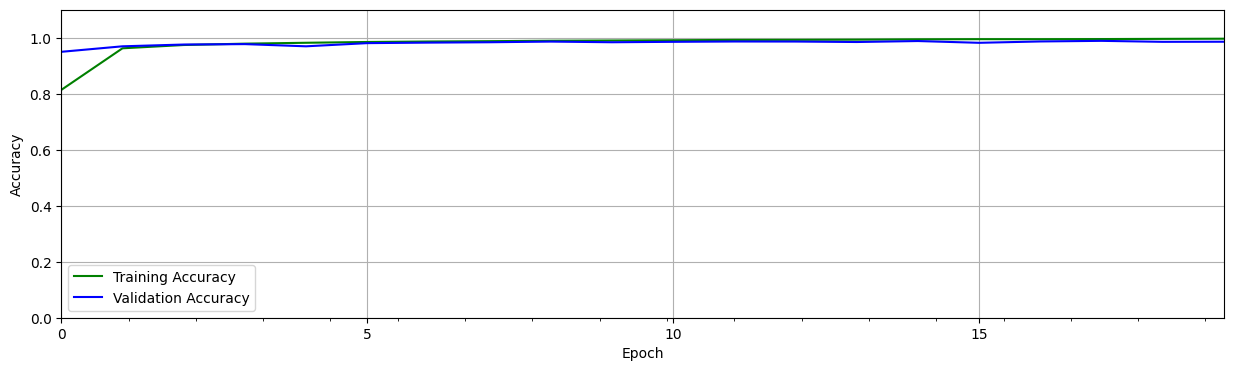

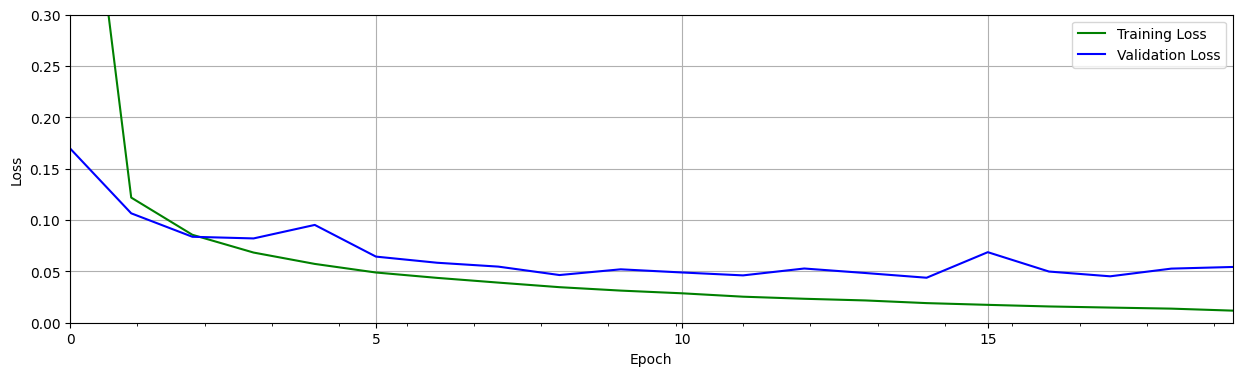

In [ ]:
# Retrieve training results.
train_loss = history["train_loss"]
train_acc  = history["train_acc"]
valid_loss = history["valid_loss"]
valid_acc  = history["valid_acc"]


train_config = history["train_config"]

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.1],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"],
            training_config=train_config)

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, 0.3],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"],
            training_config=train_config);

## 7 Model Evaluation and Plotting Predictions

We shall evaluate our model on the test data that we had created earlier and see how it performs across a sample of images.

The `evaluate_model` function computes the loss and accuracy on the test data.

In [ ]:
def evaluate_model(
    model: nn.Module,
    device: str,
    test_loader: torch.utils.data.DataLoader,
) -> None:
    #
    model.eval()

    count_sample = 0
    step_loss = 0
    step_accuracy = 0

    status = f"Evaluate: "

    prog_bar = tqdm(test_loader, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')

    prog_bar.set_description(status)

    for idx, (data, target) in enumerate(prog_bar):

        # Send data and target to appropriate device.
        data, target = data.to(device), target.to(device)

        # Get the model's predicted logits.
        with torch.no_grad():
            output = model(data)

        # Compute the CE-Loss.
        test_loss = F.cross_entropy(output, target).item()

        # Convert model's logits to probability scores.
        prob = F.softmax(output, dim=1)

        # Get the class id for the maximum score.
        pred_idx = prob.detach().argmax(dim=1)

        # Batch validation loss.
        step_loss+= test_loss * data.shape[0]

        # Batch validation accuracy.
        step_accuracy+= (pred_idx.cpu() == target.cpu()).sum()

        # Count samples.
        count_sample+= data.shape[0]

        # Update progress bar description.
        step_status = status+f"  {bold}Loss: {float(step_loss/count_sample):.4f}{reset}, "
        step_status+= f"{bold}Acc: {float(step_accuracy/count_sample):.4f}{reset}"
        prog_bar.set_description(step_status)

    prog_bar.close()

    print("\n")

    return

The `prediction_batch` function takes in the trained model and returns the class index having the highest logits. This is performed on the entire image batch.

In [ ]:
def prediction_batch(model: nn.Module, batch_inputs: torch.tensor):

    model.eval()

    with torch.no_grad():
        batch_logits = model(batch_inputs)

    batch_cls_ids = batch_logits.argmax(dim=1)

    return batch_cls_ids.cpu()

The `visualize_image_predictions` helper function is used to plot the predicted confidence scores and class indices along with target class labels. It takes in the following arguments:

- `image_batch`: The image batch to be plotted.

- `preds_batch`: The batched predictions. Each item in `preds_batch` comprises of the predicted **label**.

- `total_samples`: The total number of samples that we want to plot.

In [ ]:
def visualize_image_predictions(
    image_batch: torch.tensor,
    preds_batch: torch.tensor,
    target_batch: torch.tensor,
    total_samples: int,
   ):

    num_cols = 5
    num_rows = math.ceil(total_samples/num_cols)

    font_format = {
                    "family": "sans-serif",
                    'size': 16,
                  }

    fig = plt.figure(figsize=(18, 12))

    for i, (image, pred, target) in enumerate(zip(image_batch, preds_batch, target_batch)):

        image_np = image.squeeze().numpy()

        if pred==target:
            title_color = "g"
        else:
            title_color = "r"

        ax = plt.subplot(num_rows, num_cols, i+1)
        title = f"Tar: {int(target)}, Pred: {int(pred)}"
        title_obj = plt.title(title, fontdict=font_format)
        plt.setp(title_obj, color=title_color)
        plt.axis("off")
        plt.imshow(image_np, cmap="gray")

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()
    return

The `plot_predictions` helper function takes in the trained model and the dataloader to visualize the predictions on a few test samples. It takes in the following arguments:

- `model`: The trained model.

- `data_loader`: The dataloader for which we want to display the samples.

- `device`: The device on which to perform inference.

In [ ]:
def plot_predictions(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    device: str = "cpu",
    ):

    model = model.to(device)

    # Evaluate model performance on the test set.
    evaluate_model(model, device, data_loader)

    random.seed(42)
    num_rows = 4
    num_cols = 5
    num_data = num_rows*num_cols
    shuffled_indices = random.sample(range(len(data_loader.dataset)), num_data)

    image_batch = []
    targets_batch = []

    for idx in shuffled_indices:
        image_trans, target = data_loader.dataset[idx]
        image_batch.append(image_trans)
        targets_batch.append(target)

    image_batch = torch.stack(image_batch).to(device)
    targets_batch = torch.tensor(targets_batch)

    preds_batch = prediction_batch(model, image_batch)

    visualize_image_predictions(
                    image_batch.cpu(),
                    preds_batch,
                    targets_batch,
                    num_data,
                  )

    return

Let's prepare our dataloader along with the required transformations.

Evaluate:   Loss: 0.0381, Acc: 0.9876: 100%|██████████| 313/313 [00:04<00:00, 71.63it/s]


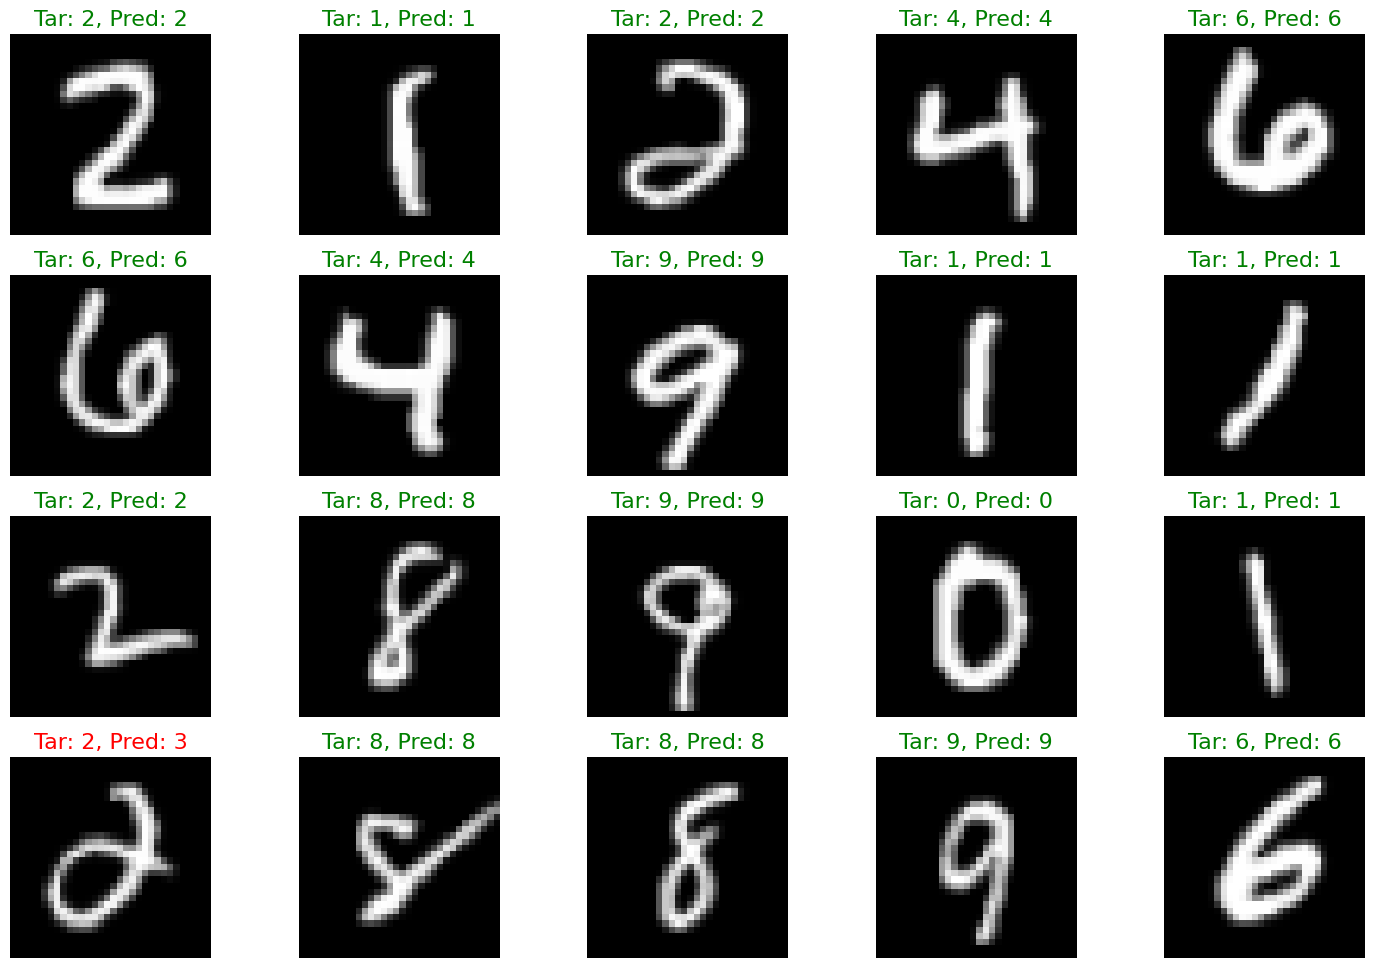

In [ ]:
trained_model = history["model"]
dataset_config = history["data_config"]

_, test_set = get_data(
                            img_size=(data_config.IMG_HEIGHT, data_config.IMG_WIDTH),
                            root_dir=data_config.DATA_ROOT,
                           )

test_loader = DataLoader(test_set,
                         batch_size=dataset_config.BATCH_SIZE,
                         shuffle=False,
                         num_workers=data_config.NUM_WORKERS)


plot_predictions(model, test_loader, train_config.DEVICE)

## 8 Conclusion

In this notebook we learned how to implement a straightforward CNN model using PyTorch, which served as a gentle introduction to the basic building blocks used in modern-day CNN architectures. We also developed more robust and modular code by incorporating more error checking and encapsulating functionality within re-usable functions.